## MFCC Model to predict song features

We will train individual models with MFCC of images as input into CNN model to predict Danceability, instrumentalness, speechiness, Energy, acousticness. There will be individual models for each of these labels to begin with, and we will work towards combining the outputs into one model.

### Import Labels and Data

In [1]:
import os
import requests
import torch

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
csv_file = "/content/drive/MyDrive/tracks_features.csv"
all_tracks = pd.read_csv(csv_file)

In [4]:
def name_of_file(track_id):
  filename = f"/content/drive/MyDrive/tracks_features_audio/{track_id}_audio.mp3"
  return filename

In [5]:
# Iterate through the DataFrame
count = 0
for index, row in all_tracks.iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    if not os.path.exists(filepath):
      print(track_id)
    else:
      count += 1
print(f"finished {count}")

1xK59OXxi2TAAAbmZK0kBL
finished 21324


### Load audio and practice converting them to MFCCs

Source: https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html

#### Testing with just waveform 

Ensure we have variety in audio samples being selected

In [ ]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

In [ ]:
for index, row in all_tracks.head().iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    print(track_id)
    WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
    waveform_mono = torch.mean(WAVEFORM, dim = 0, keepdim=True)
    print(f"Sample rate for {track_id}:", SAMPLE_RATE)
    #plot_waveform(waveform_mono, SAMPLE_RATE)


1xK59OXxi2TAAAbmZK0kBL
Sample rate for 1xK59OXxi2TAAAbmZK0kBL: 44100
4nrPB8O7Y7wsOCJdgXkthe
Sample rate for 4nrPB8O7Y7wsOCJdgXkthe: 44100
3azJifCSqg9fRij2yKIbWz
Sample rate for 3azJifCSqg9fRij2yKIbWz: 44100
78Sw5GDo6AlGwTwanjXbGh
Sample rate for 78Sw5GDo6AlGwTwanjXbGh: 44100
1Y3LN4zO1Edc2EluIoSPJN
Sample rate for 1Y3LN4zO1Edc2EluIoSPJN: 44100


We were originally just visualizing the differnt waveforms, now we're just making sure that all the audio files have the same sample_rate

### Lets create some MFCCs

Brief explanation of what is going on for the following, since I had trouble understanding MFCCs to begin with. Be warned that this explanation was provided by GPT-4 to answer the following prompt: 

"can you explain what these 5 values actually are and what an mfcc transform even does with an audio waveform. I know a waveform is basically plotting what the audio looks like where the amplitudes represent the sounds the human ear hears and the amount of those amplitude changes per second is the sample rate. I guess continue on with this explanation:

n_fft = 2048

win_length = None

hop_length = 1024

n_mels = 256

n_mfcc = 128"

These values are taken directly from the PyTorch tutorial for audio feature extraction

#### GPT-4:

MFCC stands for Mel-Frequency Cepstral Coefficients, and it is a widely-used feature extraction technique for audio signals, especially in speech and music processing. The main idea behind MFCCs is to represent the spectral shape of an audio signal in a compact and informative way that can be used for various tasks such as speech recognition, speaker identification, or music genre classification.

Here's a brief explanation of the values you mentioned:

1. n_fft (Number of FFT points): This value determines the number of points used for the Fast Fourier Transform (FFT). FFT is an algorithm that transforms the audio waveform from the time domain into the frequency domain. It essentially calculates the discrete Fourier transform (DFT) of a sequence, enabling us to analyze the frequency components of the audio signal. In this case, 2048 points are used for the FFT.
2. win_length (Window length): This value determines the size of the window applied to the audio signal before performing the FFT. If not specified (None), it usually defaults to the same value as n_fft. Window functions, such as the Hanning or Hamming window, are applied to mitigate the effect of spectral leakage caused by the finite length of the audio signal.
3. hop_length (Hop length): This value determines the number of samples between successive frames or windows in the audio signal. In this case, 1024 samples separate each frame. Overlapping frames help ensure that we capture the information between windows and provide a smoother representation of the audio signal.
4. n_mels (Number of Mel bands): The Mel scale is a perceptual scale that approximates the human ear's response to different frequencies. After performing the FFT and obtaining the spectrogram, the frequency axis is transformed into the Mel scale using a set of triangular filters. The number of Mel bands (256 in this case) determines the resolution of the Mel-scaled spectrogram, with a higher number of bands providing better frequency resolution.
5. n_mfcc (Number of MFCCs): After obtaining the Mel-scaled spectrogram, the Discrete Cosine Transform (DCT) is applied to the log power of each Mel band. The resulting coefficients are the MFCCs, which are a compact representation of the spectral shape of the audio signal. The number of MFCCs (128 in this case) determines the dimensionality of the feature vector. Generally, the lower-order MFCCs capture the coarse spectral shape, while higher-order MFCCs capture finer spectral details.
In summary, the MFCC transform takes an audio waveform, divides it into overlapping frames, calculates the frequency components using the FFT, and then converts the frequency representation into a more perceptually meaningful representation using the Mel scale. Finally, the MFCCs are calculated by applying the DCT to the log power of the Mel-scaled spectrogram, resulting in a compact representation of the spectral shape of the audio signal.

In [6]:
import librosa

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [7]:
n_fft = 4096
win_length = None
hop_length =  8192 #4096 #adjusted due to too many frames being generated, which is limited by our computational power
n_mels = 256
n_mfcc = 20

def plot_mfcc(waveform, sample_rate):
  mfcc_transform = T.MFCC(
      sample_rate=sample_rate,
      n_mfcc=n_mfcc,
      melkwargs={
          "n_fft": n_fft,
          "n_mels": n_mels,
          "hop_length": hop_length,
          "mel_scale": "htk",
      },
  )

  mfcc = mfcc_transform(waveform)
  return plot_spectrogram(mfcc[0])



1xK59OXxi2TAAAbmZK0kBL


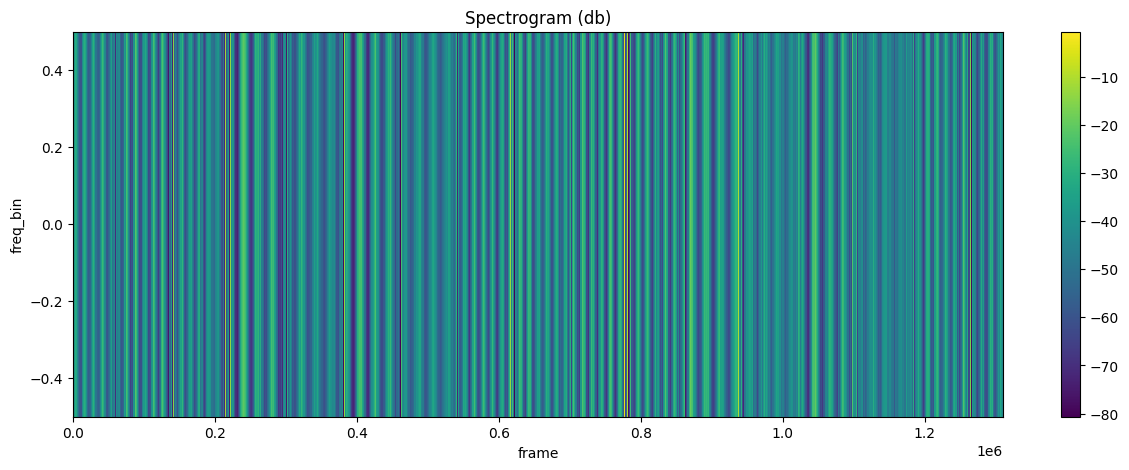

In [8]:
for index, row in all_tracks.head(1).iterrows():
    track_id = row['id']
    filepath = name_of_file(track_id)
    print(track_id)
    WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
    waveform_mono = torch.mean(WAVEFORM, dim = 0, keepdim=True)
    plot_spectrogram(waveform_mono)


Spectrograms of MFCCs appear a bit compressed, might be benefitial to just view what the MFCC looks like and maybe just feed the information from it directly into a model

### Save MFCC transforms for all audio files

Aids in being able to load them in later and avoid preprocessing

In [7]:
import torch

n_fft = 4096
win_length = None
hop_length = 8192
n_mels = 256
n_mfcc = 20

# Sample audio grabbing

row = all_tracks.iloc[0]
track_id = row['id']
filepath = name_of_file(track_id)
print(track_id)
WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
waveform_mono = torch.mean(WAVEFORM, dim=0, keepdim=True)

mfcc_transform = T.MFCC(
  sample_rate=SAMPLE_RATE,
  n_mfcc=n_mfcc,
  melkwargs={
      "n_fft": n_fft,
      "n_mels": n_mels,
      "hop_length": hop_length,
      "mel_scale": "htk",
    },
).cuda()  # Move the transform to the GPU

print("mfcc_transform shape:", mfcc_transform(waveform_mono.cuda()).shape)  # Move the waveform to the GPU

# Now for all the audio files

# Need a function to pad tensors in case shape does not match
def pad_tensor(tensor, target_frames):
  _, _, current_frames = tensor.shape
  if current_frames < target_frames:
    padding = torch.zeros(1, 20, target_frames - current_frames).cuda()
    return torch.cat((tensor, padding), dim=2)
  return tensor

mfcc_list = []

from tqdm import tqdm # progress bar stuff

for index, row in tqdm(all_tracks.iterrows(), total=all_tracks.shape[0]):
  track_id = row['id']
  filepath = name_of_file(track_id)
  WAVEFORM, SAMPLE_RATE = torchaudio.load(filepath)
  waveform_mono = torch.mean(WAVEFORM, dim=0, keepdim=True).cuda()
  mfcc = mfcc_transform(waveform_mono)
    
  # Pad the MFCC tensor to shape [1, 20, 160]
  mfcc = pad_tensor(mfcc, 160)

  # print(f"{track_id} mfcc_transform shape:", mfcc.shape)
  mfcc_list.append(mfcc)

mfcc_tensor = torch.stack(mfcc_list, dim=0)
print("Combined MFCC tensor shape:", mfcc_tensor.shape)

# save the tensor

myDrive = "/content/drive/MyDrive/"
tensor_file = os.path.join(os.path.dirname(myDrive), "mfcc_tensor.pt")

# Save the tensor
torch.save(mfcc_tensor, tensor_file)

# Load the tensor back and print the shape
loaded_mfcc_tensor = torch.load(tensor_file)
print("Loaded MFCC tensor shape:", loaded_mfcc_tensor.shape)


1xK59OXxi2TAAAbmZK0kBL
mfcc_transform shape: torch.Size([1, 20, 160])


100%|██████████| 21325/21325 [3:17:56<00:00,  1.80it/s]


Combined MFCC tensor shape: torch.Size([21325, 1, 20, 160])
Loaded MFCC tensor shape: torch.Size([21325, 1, 20, 160])


After having experimented with various values for the MFCC parameters, we are settling with the following for each:

n_fft = 4096

win_length = None

hop_length = 1024 (8192 now because too many frames)

n_mels = 256

n_mfcc = 20

Part of our experimentation process will be to change n_mfcc to 40 and change win_length to 1024 such that we have shorter windows to capture more time-varying information at the expense of frequency resolution

Also I'm making the decision to feed the mfcc directly into the model as a 2D tensor. The first argument in the printed shape above represents the batch size. The second arguement is the number of MFCC coefficients. The last arguement represents the number of frames in the MFCC representation of the image. Given our hop_length of (8192), clip length of 30 seconds that are sampled at 44100 Hz, we are looking at about (30 * 44100)/8192 frames. The edge effects of windowing and padding possibly contributes to this number being slightly lower than the actual value. 

### Putting the data through the neural network

#### Data loading task
This first section is going to see us define a class for handling our dataset. This is because we originally have all information related to the data stored in a CSV file. Our goal is to extract the audio and create mfccs for them. And then we also associate the labels using our dataset class. We will perform some normalizing on both the Waveform such that it is on a single channel rather than being stereo. We will also experiment with rescaling the waveforms to be between [-1,1] instead of the current [0,1], and also maybe perform standard scaling. This will all come after first just getting MFCCs for the raw waveforms. We already know that the sample rate is set to be 44,100 Hz for all the audio tracks do we wont have to do naything there. For the actual MFCCs, we will need to add an extra dimention to represent the channel since CNNs expect that dimention. We will also scale the MCFF coefficients to have 0 mean and unit variance. This is just standard normalization since we will actually be feeding the MFCCs into our model. The things I mentioned to do to the waveform might not be necessary. This may also have to be experiemnted with. 

In [ ]:
from torch.utils.data import Dataset

class AudioDataset(Dataset):
  def __init__(self, tracks_df, mfcc_transform):
    self.tracks_df = tracks_df
    self.mfcc_transform = mfcc_transform

  def __len__(self):
    return len(self.tracks_df)

  def __getitem__(self, idx):
    current_id = self.tracks_df.iloc[idx]['id']
    file_path = name_of_file(current_id)
    wf, sr = torchaudio.load(file_path)

    # convert waveform to mono
    wf_mono = torch.mean(wf, dim=0, keepdim=True)

    # # for experimentation later: 
    # wf_std = (wf_mono - wf_mono.mean()) / wf_mono.std()

    # # for other experimentation later
    # wf_std = self.normalize_waveform(wf_mono)

    mfcc = self.mfcc_transform(wf_mono)
    mfcc = self.standardize_mfcc(mfcc) # might comment out later and experiment without this
    # mfcc = mfcc.unsqueeze(1) # this is however, very necessary (or not?)
    mfcc = torch.squeeze(mfcc)
    
    #label = self.tracks_df.iloc[idx]['danceability']
    label = torch.tensor(self.tracks_df.iloc[idx]['danceability'], dtype=torch.float32).unsqueeze(0)

    # Create new tensors with resizable storage
    mfcc_resizable = mfcc.clone().detach().requires_grad_(mfcc.requires_grad)
    label_resizable = label.clone().detach().requires_grad_(label.requires_grad)

    return mfcc_resizable, label_resizable # torch.tensor(label, dtype=torch.float32)
    #return super().__getitem__(index)

  # This first function is most likely going unused. It is there to rescale the waveforms to be between [-1,1] isntead of [0,1]
  @staticmethod
  def normalize_waveform(waveform):
    min_val = waveform.min()
    max_val = waveform.max()
    waveform = (waveform - min_val) / (max_val - min_val + 1e-8)
    waveform = 2 * waveform - 1
    return waveform

  @staticmethod
  def standardize_mfcc(mfcc):
    mean = mfcc.mean(dim=-1, keepdim=True)
    std = mfcc.std(dim=-1, keepdim=True)
    mfcc = (mfcc - mean) / (std + 1e-8)  # Add a small constant to avoid division by zero
    return mfcc

#### Train test validation 

We now define a basic neural network, divide out our dataset, and perform some training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
  def __init__(self, num_classes=1):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    self.fc1 = nn.Linear(32 * 5 * 320, 64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)    
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = x.view(-1, 32 * 5 * 320)
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    # Multiply by 1000, round, and then divide by 1000 for precision purposes
    x = torch.round(x * 1000) / 1000

    return x


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


train_df, test_val_df = train_test_split(all_tracks, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

# Instantiate the MFCC feature extractor
n_fft = 4096
win_length = None
hop_length = 1024
n_mels = 256
n_mfcc = 20

mfcc_transform = T.MFCC(
    sample_rate=44100,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

def custom_collate_fn(batch):
  # Separate the MFCC tensors and labels
  inputs, labels = zip(*batch)

  # Pad the MFCC tensors to have the same size
  inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
  
  # Stack the labels into a single tensor
  labels = torch.stack(labels)

  return inputs, labels


train_dataset = AudioDataset(train_df, mfcc_transform)
val_dataset = AudioDataset(val_df, mfcc_transform)
test_dataset = AudioDataset(test_df, mfcc_transform)

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
  print(f"working on epoch: {epoch}")
  model.train()
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(train_loader):
    # Permute dimensions to [batch_size, channels, height, width]
    inputs = inputs.unsqueeze(1)
    inputs = inputs.permute(0, 1, 2, 3)
    inputs, labels = inputs.to(device), labels.to(device)
        
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
        
    running_loss += loss.item()

  epoch_loss = running_loss / (i + 1)
  print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  # Validation
  model.eval()
  val_running_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_running_loss += loss.item()

  val_epoch_loss = val_running_loss / len(val_loader)
  print(f"Validation Loss: {val_epoch_loss:.4f}")


In [ ]:
model.eval()
test_running_loss = 0.0
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_running_loss += loss.item()

test_loss = test_running_loss / len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


### Attempt 2 at training model

This time we have precomputed the MFCCs and reduced the frames to take some of the work load off our dataloader

#### First we load in our saved MFCC dataframe

In [5]:

class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, mfcc_tensor, df):
    self.df = df
    self.mfcc = mfcc_tensor
    self.mean = self.mfcc.mean()
    self.std = self.mfcc.std()

    # Standardize MFCC tensor
    self.mfcc = (self.mfcc - self.mean) / self.std

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    label = torch.tensor(self.df.iloc[idx]['danceability'], dtype=torch.float32)
    mfcc = self.mfcc[idx]
    return mfcc, label


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Load the MFCC tensor
myDrive = "/content/drive/MyDrive/"
tensor_file = os.path.join(os.path.dirname(myDrive), "mfcc_tensor.pt")
loaded_mfcc_tensor = torch.load(tensor_file).squeeze(1)
print("Loaded MFCC tensor shape:", loaded_mfcc_tensor.shape)

# Split all_tracks and the loaded MFCC tensor
train_tracks, test_val_tracks = train_test_split(all_tracks, test_size=0.3, random_state=42)
test_tracks, val_tracks = train_test_split(test_val_tracks, test_size=0.5, random_state=42)

train_mfcc, test_val_mfcc = train_test_split(loaded_mfcc_tensor, test_size=0.3, random_state=42)
test_mfcc, val_mfcc = train_test_split(test_val_mfcc, test_size=0.5, random_state=42)

# Create the datasets
train_dataset = AudioDataset(train_mfcc, train_tracks)
val_dataset = AudioDataset(val_mfcc, val_tracks)
test_dataset = AudioDataset(test_mfcc, test_tracks)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


Loaded MFCC tensor shape: torch.Size([21325, 20, 160])


#### 2D CNN Model:

Treating the MFCC/frames as images and using a 2D CNN can help capture local patterns and structures in the spectrograms. CNNs are efficient in extracting features from fixed-size inputs, like images. In this case, since the MFCC tensors are of a fixed size [20, 160], a 2D CNN can work well. 2D CNNs can also handle variations in the time and frequency domains simultaneously, making them suitable for audio-related tasks.

In [7]:
import torch.nn as nn

# 2D CNN Model
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.fc1 = nn.Linear(32 * 5 * 40, 64)
    self.fc2 = nn.Linear(64, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = nn.functional.relu(self.conv1(x))
    x = nn.functional.max_pool2d(x, 2)
    x = nn.functional.relu(self.conv2(x))
    x = nn.functional.max_pool2d(x, 2)
    x = x.view(x.size(0), -1)
    x = nn.functional.relu(self.fc1(x))
    x = self.fc2(x)

    x = self.sigmoid(x)
    
    # Multiply by 1000, round, and then divide by 1000 for precision purposes
    x = torch.round(x * 1000) / 1000

    return x

In [12]:
import torch.optim as optim
from tqdm import tqdm # progress bar stuff
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-9)

num_epochs = 20
for epoch in range(num_epochs):
  print(f"working on epoch: {epoch}")
  model.train()
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(tqdm(train_loader)):
    inputs, labels = inputs.to(device), labels.to(device)
    #inputs = inputs.permute(1,0,2)
    inputs = inputs.unsqueeze(1)
    #inputs = inputs.permute(0,1,2,3)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()

  epoch_loss = running_loss / (i + 1)
  print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  # Validation
  model.eval()
  val_running_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      inputs = inputs.unsqueeze(1)
      #inputs = inputs.permute(0,1,2,3)
      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), labels)
      val_running_loss += loss.item()

  val_epoch_loss = val_running_loss / len(val_loader)
  print(f"Validation Loss: {val_epoch_loss:.4f}")


working on epoch: 0


100%|██████████| 467/467 [00:03<00:00, 131.12it/s]


Epoch [1/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 1


100%|██████████| 467/467 [00:04<00:00, 115.51it/s]


Epoch [2/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 2


100%|██████████| 467/467 [00:03<00:00, 118.06it/s]


Epoch [3/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 3


100%|██████████| 467/467 [00:03<00:00, 127.38it/s]


Epoch [4/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 4


100%|██████████| 467/467 [00:04<00:00, 107.98it/s]


Epoch [5/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 5


100%|██████████| 467/467 [00:05<00:00, 91.14it/s] 


Epoch [6/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 6


100%|██████████| 467/467 [00:03<00:00, 132.98it/s]


Epoch [7/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 7


100%|██████████| 467/467 [00:03<00:00, 132.81it/s]


Epoch [8/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 8


100%|██████████| 467/467 [00:04<00:00, 105.66it/s]


Epoch [9/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 9


100%|██████████| 467/467 [00:03<00:00, 130.85it/s]


Epoch [10/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 10


100%|██████████| 467/467 [00:03<00:00, 132.05it/s]


Epoch [11/20] - Loss: 0.0413
Validation Loss: 0.0415
working on epoch: 11


100%|██████████| 467/467 [00:04<00:00, 110.39it/s]


Epoch [12/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 12


100%|██████████| 467/467 [00:03<00:00, 123.58it/s]


Epoch [13/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 13


100%|██████████| 467/467 [00:03<00:00, 134.10it/s]


Epoch [14/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 14


100%|██████████| 467/467 [00:05<00:00, 82.57it/s]


Epoch [15/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 15


100%|██████████| 467/467 [00:03<00:00, 128.83it/s]


Epoch [16/20] - Loss: 0.0413
Validation Loss: 0.0415
working on epoch: 16


100%|██████████| 467/467 [00:03<00:00, 130.58it/s]


Epoch [17/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 17


100%|██████████| 467/467 [00:03<00:00, 119.30it/s]


Epoch [18/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 18


100%|██████████| 467/467 [00:03<00:00, 118.27it/s]


Epoch [19/20] - Loss: 0.0412
Validation Loss: 0.0415
working on epoch: 19


100%|██████████| 467/467 [00:03<00:00, 132.48it/s]


Epoch [20/20] - Loss: 0.0412
Validation Loss: 0.0415


In [28]:
!nvidia-smi



Sat Apr 15 06:27:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    26W /  70W |   2181MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
# Test
model.eval()
test_running_loss = 0.0
test_mae = 0.0
test_mse = 0.0
test_preds = []
test_true_vals = []

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.unsqueeze(1)

    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    test_running_loss += loss.item()

    # Compute evaluation metrics
    test_preds.extend(outputs.squeeze().tolist())
    test_true_vals.extend(labels.tolist())
    test_mae += torch.sum(torch.abs(outputs.squeeze() - labels)).item()
    test_mse += torch.sum((outputs.squeeze() - labels)**2).item()

test_epoch_loss = test_running_loss / len(test_loader)
test_preds = torch.tensor(test_preds)
test_true_vals = torch.tensor(test_true_vals)
test_mae /= len(test_dataset)
test_mse /= len(test_dataset)

print(f"Test Loss: {test_epoch_loss:.4f}")
print(f"Test Mean Absolute Error: {test_mae:.4f}")
print(f"Test Mean Squared Error: {test_mse:.4f}")



Test Loss: 0.0409
Test Mean Absolute Error: 0.1693
Test Mean Squared Error: 0.0409


#### 1D RNN Model:

Using a 1D RNN model is beneficial when you want to capture the temporal dependencies in the data. RNNs, specifically LSTMs and GRUs, are designed to handle sequences and are capable of remembering information from previous time steps. If the temporal relationship between the frames is critical in this task, an RNN-based model can be more appropriate. However, RNNs might be slower to train and more prone to vanishing gradient issues when compared to CNNs.

In [14]:
# 1D RNN Model
import torch.nn as nn

class RNNModel(nn.Module):
  def __init__(self, input_size=20, hidden_size=64, num_layers=1):
    super(RNNModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar stuff
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
for epoch in range(num_epochs):
  print(f"working on epoch: {epoch}")
  model.train()
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(tqdm(train_loader)):
    # Permute dimensions to [batch_size, sequence_length, input_size]
    inputs = inputs.permute(0, 2, 1)
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()

  epoch_loss = running_loss / (i + 1)
  print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  # Validation
  model.eval()
  val_running_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.permute(0, 2, 1)
      inputs, labels = inputs.to(device), labels.to(device)
      
      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), labels)
      val_running_loss += loss.item()

  val_epoch_loss = val_running_loss / len(val_loader)
  print(f"Validation Loss: {val_epoch_loss:.4f}")


working on epoch: 0


100%|██████████| 467/467 [00:04<00:00, 114.52it/s]


Epoch [1/20] - Loss: 0.0303
Validation Loss: 0.0184
working on epoch: 1


100%|██████████| 467/467 [00:03<00:00, 149.20it/s]


Epoch [2/20] - Loss: 0.0178
Validation Loss: 0.0175
working on epoch: 2


100%|██████████| 467/467 [00:03<00:00, 122.22it/s]


Epoch [3/20] - Loss: 0.0166
Validation Loss: 0.0158
working on epoch: 3


100%|██████████| 467/467 [00:02<00:00, 155.76it/s]


Epoch [4/20] - Loss: 0.0153
Validation Loss: 0.0199
working on epoch: 4


100%|██████████| 467/467 [00:02<00:00, 161.55it/s]


Epoch [5/20] - Loss: 0.0143
Validation Loss: 0.0137
working on epoch: 5


100%|██████████| 467/467 [00:03<00:00, 126.12it/s]


Epoch [6/20] - Loss: 0.0129
Validation Loss: 0.0125
working on epoch: 6


100%|██████████| 467/467 [00:03<00:00, 145.10it/s]


Epoch [7/20] - Loss: 0.0123
Validation Loss: 0.0123
working on epoch: 7


100%|██████████| 467/467 [00:02<00:00, 160.27it/s]


Epoch [8/20] - Loss: 0.0120
Validation Loss: 0.0121
working on epoch: 8


100%|██████████| 467/467 [00:02<00:00, 163.02it/s]


Epoch [9/20] - Loss: 0.0116
Validation Loss: 0.0115
working on epoch: 9


100%|██████████| 467/467 [00:04<00:00, 111.85it/s]


Epoch [10/20] - Loss: 0.0112
Validation Loss: 0.0116
working on epoch: 10


100%|██████████| 467/467 [00:02<00:00, 160.31it/s]


Epoch [11/20] - Loss: 0.0110
Validation Loss: 0.0138
working on epoch: 11


100%|██████████| 467/467 [00:02<00:00, 158.49it/s]


Epoch [12/20] - Loss: 0.0106
Validation Loss: 0.0108
working on epoch: 12


100%|██████████| 467/467 [00:03<00:00, 149.72it/s]


Epoch [13/20] - Loss: 0.0104
Validation Loss: 0.0109
working on epoch: 13


100%|██████████| 467/467 [00:04<00:00, 99.26it/s] 


Epoch [14/20] - Loss: 0.0102
Validation Loss: 0.0110
working on epoch: 14


100%|██████████| 467/467 [00:03<00:00, 144.64it/s]


Epoch [15/20] - Loss: 0.0099
Validation Loss: 0.0108
working on epoch: 15


100%|██████████| 467/467 [00:03<00:00, 155.35it/s]


Epoch [16/20] - Loss: 0.0099
Validation Loss: 0.0105
working on epoch: 16


100%|██████████| 467/467 [00:04<00:00, 111.28it/s]


Epoch [17/20] - Loss: 0.0097
Validation Loss: 0.0102
working on epoch: 17


100%|██████████| 467/467 [00:02<00:00, 159.61it/s]


Epoch [18/20] - Loss: 0.0096
Validation Loss: 0.0100
working on epoch: 18


100%|██████████| 467/467 [00:02<00:00, 159.16it/s]


Epoch [19/20] - Loss: 0.0093
Validation Loss: 0.0102
working on epoch: 19


100%|██████████| 467/467 [00:03<00:00, 121.43it/s]


Epoch [20/20] - Loss: 0.0093
Validation Loss: 0.0099


working on epoch: 0


100%|██████████| 467/467 [00:03<00:00, 129.73it/s]


Epoch [1/20] - Loss: 0.0251
Validation Loss: 0.0209
working on epoch: 1


100%|██████████| 467/467 [00:03<00:00, 116.78it/s]


Epoch [2/20] - Loss: 0.0165
Validation Loss: 0.0166
working on epoch: 2


100%|██████████| 467/467 [00:02<00:00, 159.70it/s]


Epoch [3/20] - Loss: 0.0144
Validation Loss: 0.0141
working on epoch: 3


100%|██████████| 467/467 [00:03<00:00, 154.43it/s]


Epoch [4/20] - Loss: 0.0129
Validation Loss: 0.0131
working on epoch: 4


100%|██████████| 467/467 [00:02<00:00, 159.96it/s]


Epoch [5/20] - Loss: 0.0125
Validation Loss: 0.0127
working on epoch: 5


100%|██████████| 467/467 [00:04<00:00, 116.66it/s]


Epoch [6/20] - Loss: 0.0118
Validation Loss: 0.0122
working on epoch: 6


100%|██████████| 467/467 [00:02<00:00, 157.68it/s]


Epoch [7/20] - Loss: 0.0117
Validation Loss: 0.0117
working on epoch: 7


100%|██████████| 467/467 [00:02<00:00, 160.15it/s]


Epoch [8/20] - Loss: 0.0112
Validation Loss: 0.0113
working on epoch: 8


100%|██████████| 467/467 [00:03<00:00, 133.39it/s]


Epoch [9/20] - Loss: 0.0108
Validation Loss: 0.0110
working on epoch: 9


100%|██████████| 467/467 [00:03<00:00, 132.49it/s]


Epoch [10/20] - Loss: 0.0107
Validation Loss: 0.0124
working on epoch: 10


100%|██████████| 467/467 [00:02<00:00, 159.35it/s]


Epoch [11/20] - Loss: 0.0105
Validation Loss: 0.0107
working on epoch: 11


100%|██████████| 467/467 [00:02<00:00, 156.09it/s]


Epoch [12/20] - Loss: 0.0102
Validation Loss: 0.0118
working on epoch: 12


100%|██████████| 467/467 [00:04<00:00, 112.75it/s]


Epoch [13/20] - Loss: 0.0100
Validation Loss: 0.0108
working on epoch: 13


100%|██████████| 467/467 [00:02<00:00, 157.34it/s]


Epoch [14/20] - Loss: 0.0100
Validation Loss: 0.0103
working on epoch: 14


100%|██████████| 467/467 [00:02<00:00, 156.56it/s]


Epoch [15/20] - Loss: 0.0097
Validation Loss: 0.0106
working on epoch: 15


100%|██████████| 467/467 [00:03<00:00, 128.18it/s]


Epoch [16/20] - Loss: 0.0097
Validation Loss: 0.0105
working on epoch: 16


100%|██████████| 467/467 [00:04<00:00, 94.08it/s] 


Epoch [17/20] - Loss: 0.0095
Validation Loss: 0.0104
working on epoch: 17


100%|██████████| 467/467 [00:02<00:00, 158.76it/s]


Epoch [18/20] - Loss: 0.0096
Validation Loss: 0.0101
working on epoch: 18


100%|██████████| 467/467 [00:02<00:00, 156.21it/s]


Epoch [19/20] - Loss: 0.0093
Validation Loss: 0.0100
working on epoch: 19


100%|██████████| 467/467 [00:04<00:00, 114.06it/s]


Epoch [20/20] - Loss: 0.0092
Validation Loss: 0.0105


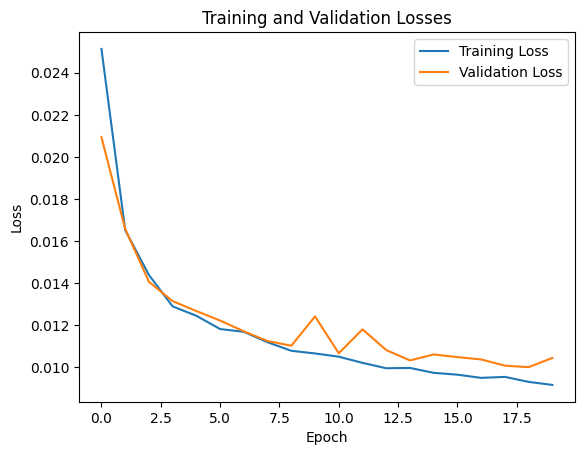

In [17]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar stuff
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):
  print(f"working on epoch: {epoch}")
  model.train()
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(tqdm(train_loader)):
    inputs = inputs.permute(0, 2, 1)
    inputs, labels = inputs.to(device), labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()

  epoch_loss = running_loss / (i + 1)
  train_losses.append(epoch_loss)
  print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

  model.eval()
  val_running_loss = 0.0
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.permute(0, 2, 1)
      inputs, labels = inputs.to(device), labels.to(device)
      
      outputs = model(inputs)
      loss = criterion(outputs.squeeze(), labels)
      val_running_loss += loss.item()

  val_epoch_loss = val_running_loss / len(val_loader)
  val_losses.append(val_epoch_loss)
  print(f"Validation Loss: {val_epoch_loss:.4f}")

# Plotting the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

model.eval()
all_outputs = []
all_labels = []

with torch.no_grad():
  for inputs, labels in test_loader:
      inputs = inputs.permute(0, 2, 1)
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = model(inputs)
      all_outputs.extend(outputs.squeeze().tolist())
      all_labels.extend(labels.tolist())

mse = mean_squared_error(all_labels, all_outputs)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_outputs)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 0.0104
RMSE: 0.1018
MAE: 0.0786


In [19]:
# Assuming the directory path is saved in the variable `data_directory`
data_directory = "/content/drive/MyDrive/"
model_weights_path = os.path.join(data_directory, "rnn_model_weights.pth")

# Save the model weights
torch.save(model.state_dict(), model_weights_path)
